# Noise audio preprocessing

In [1]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "05_Utilities") ## full path to the "05_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "05_Utilities" folder to the sys.path list
from audioProcessing import processAudio ## modul for audio file processing and mel-spectrogram generation
from spectrogramPlotting import spectrogramPlotter ## modul for mel-spectrogram visualization

# make instances of the classes in the modules
processAudio = processAudio()
spectrogramPlotter = spectrogramPlotter()

In [3]:
# list all audio file datasets in folder "01_Dataset/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir_path = os.path.join(cwd, audio_datasets_main_dir_name) ## path to the "01_audioDatasets" folder
audio_datasets = [] ## list of audio datasets

if os.path.exists(audio_datasets_main_dir_path):
    for i in os.listdir(audio_datasets_main_dir_path):
        ##if folder name does not start with a dot -> to avoid hidden folders
        if i[0] != ".": 
            audio_datasets.append(i) ## add the folder name to the list of audio datasets
    audio_datasets = sorted(audio_datasets) ## sort the list of audio datasets by name
else:
    print("\"01_audioDatasets\" directory does not exist or the path is incorrect.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [5]:
# select the noise dataset

## with the initial folder structure, the noise dataset is the 6th in the list

dataset_num = 6 ## ID of noise audio dataset

print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  07_Noise_Samples


In [9]:
# add all audio files from noise dataset to a list

audio_dataset_dir_path = os.path.join(audio_datasets_main_dir_path, audio_datasets[dataset_num]) ## path to the noise dataset
audio_files = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.m4a')] ## list of audio files in the noise dataset
audio_files_sorted = sorted(audio_files) ## sort the list of audio files by name

print(f"Dataset length: {len(audio_files_sorted)}")

print("First 5 file in the noise dataset:")
for i in range(5): print(audio_files_sorted[i])

Dataset length: 13
First 5 file in the noise dataset:
01_Reference_level_production.m4a
02_Screws.m4a
03_Hex_keys.m4a
04_Plastic_part.m4a
05_Screw_drivers.m4a


In [31]:
# constant parameters from the notebook "preprocessing_audio_wo_additional_noise.ipynb"

sampling_rate = 32000

chunk_size = 4096 # number of samples in one chunk of audio data
spectrogram_columns_per_chunk = 8 # number of spectrogram columns in one chunk of audio data

resolution = (chunk_size/sampling_rate)/spectrogram_columns_per_chunk # 0.016 seconds when processing a chunk of 4096 samples at a sampling rate of 32 kHz with 8 spectrogram columns per chunk

hop_length = int(resolution * sampling_rate) # the number of samples between successive frames in the STFT

n_mels = 128 # number of mel bands (rows in the mel-scaled spectrogram), 128 is a common value

f_min = 20 # minimum frequency in Hz, from the microphone specification
f_max = 14000 # maximum frequency in Hz, the microphone has a max frequency response of 20 kHz, however, the sampling rate is 32 kHz, so the max frequency can be 16 kHz or lower

dB_ref = 1e3 # reference value for dB conversion
a_squere_min = 1e-12 # larger than 0 to avoid log(0)
top_dB_abs = abs(10*np.log10(a_squere_min)) # maximum dB value -> 10*log(a_squere_min) = -120

Selected file: 09_Metal_wrench_production.m4a


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/getMelSpectrogram.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


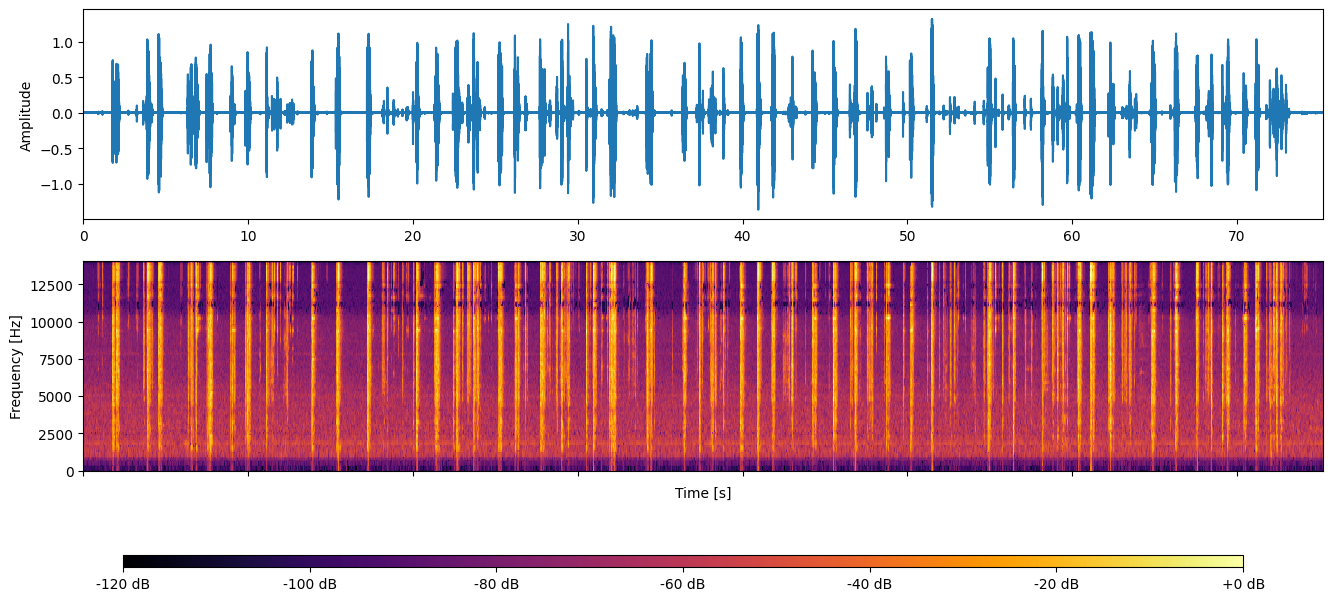

In [32]:
# plot the wave and mel spectrogram of an audio file from the noise dataset

file_id_num = 8 # selected file ID number

print(f"Selected file: {audio_files_sorted[file_id_num]}")

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

In [33]:
# window parameters for splitting all audio files into chunks

time_interval = (chunk_size/sampling_rate) * 4
window_size_sec = time_interval # 0.512 seconds, corresponds to 4 chunks with 4096 samples each, should be larger than the click event duration!!
window_size = int(window_size_sec / resolution) # spectrogram columns in the window
step_size_sec = 0.128 # in seconds, corresponds to a chunks with 4096 samples --> overlap
step_size = int(step_size_sec / resolution)
print(window_size, step_size)

window_size_long = window_size * 2
print(window_size_long)

32 8
64


In [34]:
# calculate the max dB value in the reference silence audio file

file_id_num = 0 # ID of the reference silence audio file
audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)

max_dB_reference = np.max(D_mel_dB)
max_dB_reference

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/getMelSpectrogram.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


-28.197819

In [35]:
# get audio spectrograms for all audio files in the noise dataset except the reference silence audio file

audio_files_exept_ref = audio_files_sorted.copy()
audio_files_exept_ref.pop(0) # remove the reference silence audio file

spectrograms = []
signals = []
signal_times = []

for audio_file in audio_files_exept_ref:
    audio_file_path = os.path.join(audio_dataset_dir, audio_file)
    signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrograms.append(D_mel_dB)
    signals.append(signal)
    signal_times.append(time)


In [36]:
# create spectrogram chunks and corresponding labels (0) for the selected dataset (excluding the reference silence file)

spec_chunk_dataset = []
spec_chunk_labels = []
signal_chunks = []
time_chunks = []

spec_chunk_dataset_long_window = []
spec_chunk_labels_long_window = []
signal_chunks_long_window = []
time_chunks_long_window = []

dB_threshold = max_dB_reference + abs(max_dB_reference) * 0.3 # threshold for noise chunks

def createSpectrogramDataset(spectrograms, signals, signal_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            label = 0 # no click event

            if np.max(spectrogram_chunk) > dB_threshold:
                spec_chunk_dataset.append(spectrogram_chunk)
                spec_chunk_labels.append(label)
                signal_chunks.append(signal_chunk)
                time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

def createSpectrogramDatasetLongWindow(spectrograms, signals, signal_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]

        for start_idx in range(0, spectrogram.shape[1] - window_size_long, step_size):
            end_idx = start_idx + window_size_long
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            label = 0 # no click event

            if np.max(spectrogram_chunk) > dB_threshold:
                spec_chunk_dataset_long_window.append(spectrogram_chunk)
                spec_chunk_labels_long_window.append(label)
                signal_chunks_long_window.append(signal_chunk)
                time_chunks_long_window.append(time_chunk)

    return spec_chunk_dataset_long_window, spec_chunk_labels_long_window, signal_chunks_long_window, time_chunks_long_window

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times)

spec_chunk_dataset_long_window, spec_chunk_labels_long_window, signal_chunks_long_window, time_chunks_long_window = createSpectrogramDatasetLongWindow(spectrograms, signals, signal_times)

print(len(spec_chunk_dataset)) # number of spectrogram chunks
print(len(spec_chunk_labels)) # number of labels

print(len(spec_chunk_dataset_long_window)) # number of spectrogram chunks
print(len(spec_chunk_labels_long_window)) # number of labels

2364
2364
3708
3708


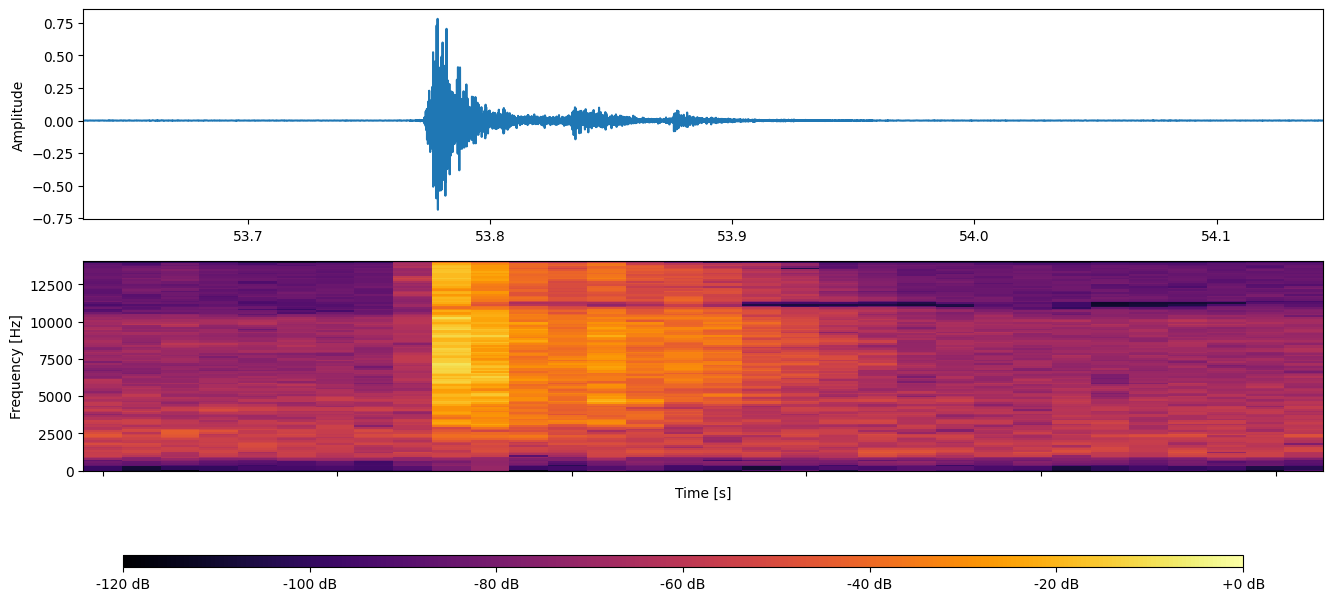

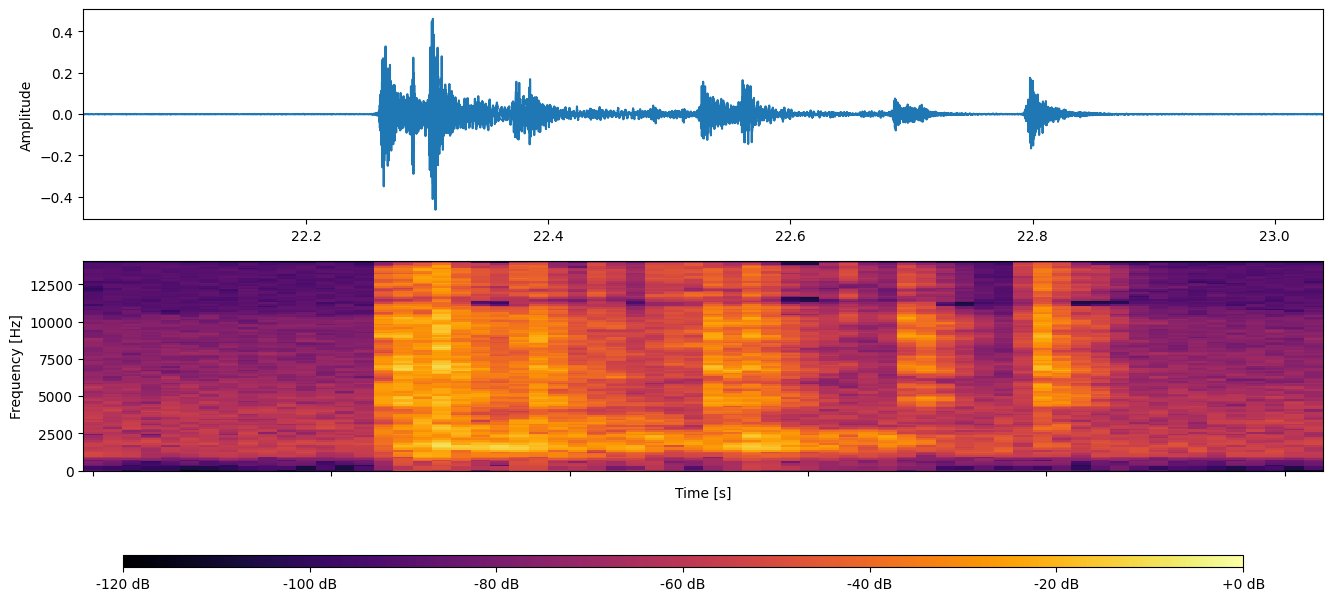

In [37]:
# plot chunk

chunk_id_to_plot = 2300

if chunk_id_to_plot < len(spec_chunk_dataset):
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("Chunk ID out of range")

# plot a sample from the long window dataset

if chunk_id_to_plot < len(spec_chunk_dataset_long_window):
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal_chunks_long_window[chunk_id_to_plot], time_chunks_long_window[chunk_id_to_plot], spec_chunk_dataset_long_window[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("Chunk ID out of range")



In [38]:
# save the noise spectrogram dataset and labels in .npz format into the same directory as the noise audio files

save_directory = audio_dataset_dir
filename = "noise_dataset.npz"
filename_long_window = "noise_dataset_long_window.npz"

file_fullpath = os.path.join(save_directory, filename)
file_fullpath_long_window = os.path.join(save_directory, filename_long_window)

spec_chunk_dataset = np.array(spec_chunk_dataset)
spec_chunk_labels = np.array(spec_chunk_labels)

spec_chunk_dataset_long_window = np.array(spec_chunk_dataset_long_window)
spec_chunk_labels_long_window = np.array(spec_chunk_labels_long_window)

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)
np.savez(file_fullpath_long_window, spec_chunks=spec_chunk_dataset_long_window, labels=spec_chunk_labels_long_window)

(128, 32)
2364
2364


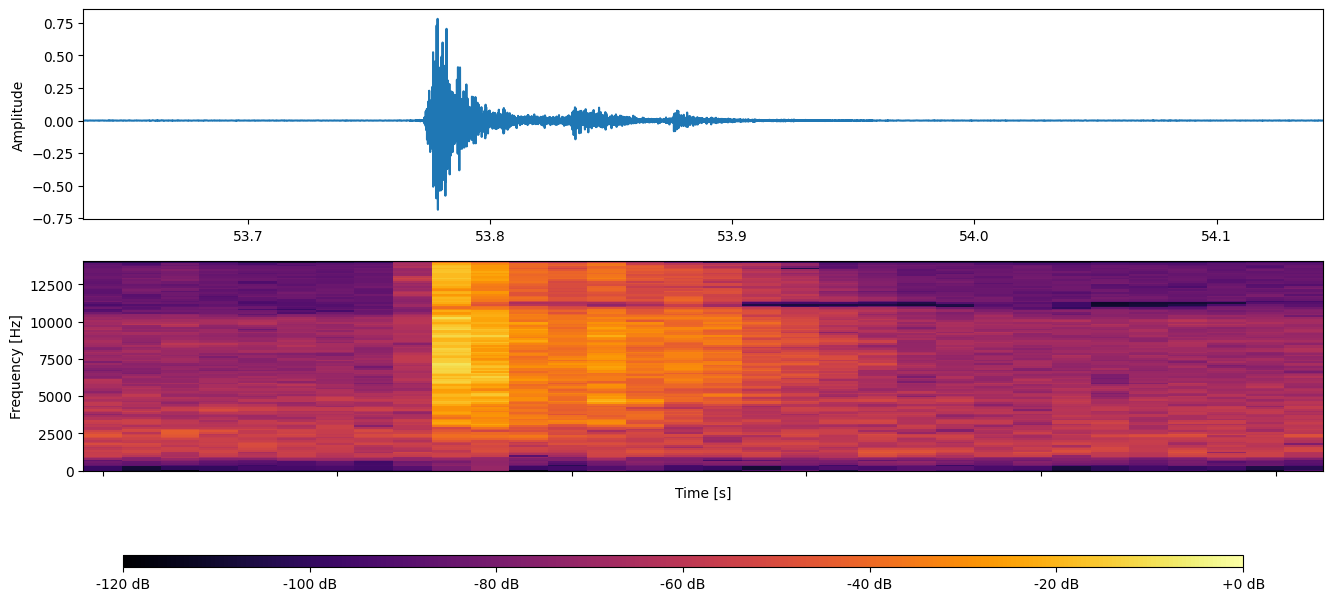

In [39]:
# check if the saved dataset can be loaded

data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))

# plot out one spectrogram chunk
spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)